In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

def add_to_path(dir_path):
    if dir_path not in sys.path:
        sys.path.insert(0, dir_path)
        
add_to_path('src')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchsummaryX import summary

from PIL import Image

import matplotlib.pyplot as plt

from sample_utils import sample_bernoulli, sample_gaussean_sp

# Work

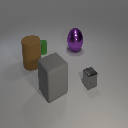

In [4]:
GLIMPSE_SHAPE = (32, 32)
IMAGE_SHAPE = (128, 128)
img = Image.open('/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/images/val/CLEVR_val_000000.png')
img = img.convert('RGB').resize(IMAGE_SHAPE)
transform = T.Compose((
    # (T.Resize(IMAGE_SHAPE),
    T.ToTensor(),
))
x = transform(img)
batch = x.unsqueeze(0)
img

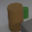

In [115]:
theta = torch.tensor([[
    0.3, 0, -0.5, 0, 0.3, -0.2
]], dtype=torch.float)# transformation, zero values are crop skewness, for now without skew
# theta = torch.cat([theta_w, torch.zeros_like(theta_w), theta_ty, torch.zeros_like(theta_w), theta_h, theta_tx], dim=-1)

_theta = theta.view(-1, 2, 3)
grid = F.affine_grid(_theta, (_theta.size(0), C, *GLIMPSE_SHAPE), align_corners=False)
# repeat each image Hp * Wp times for each cropping
_x = batch.unsqueeze(1).expand(-1, Hp * Wp, -1, -1, -1)
_x = _x.view(-1, C, H, W)
xs = F.grid_sample(batch, grid, align_corners=False)

T.functional.to_pil_image(xs[0])

In [121]:
eye = torch.eye(3).unsqueeze(0)
eye.requires_grad_(True)
eye.inverse()

tensor([[[1., 0., -0.],
         [0., 1., -0.],
         [0., 0., 1.]]], grad_fn=<InverseBackward>)

In [127]:
def inverse_affine(theta, image, out_shape):
    bsz = theta.size(0)
    t = torch.tensor([0., 0., 1.]).repeat(bsz, 1, 1)
    t = torch.cat([theta, t], dim=-2)
    t = t.inverse()
    theta = t[:, :2, :]
    grid = F.affine_grid(theta, (bsz, image.size(1), *out_shape), align_corners=False)
    input_glimpses = F.grid_sample(image, grid, align_corners=False)
    return input_glimpses

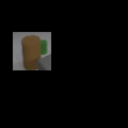

In [133]:
T.functional.to_pil_image(inverse_affine(_theta, xs.requires_grad_(True), (128, 128))[0])

## Foreground Inference

In [30]:
from modules import ImgEncoder

bsz, C, H, W = batch.size()
image_shape = torch.tensor((H, W), dtype=torch.float, device=x.device)

encoder = ImgEncoder()
encoder

ImgEncoder(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): GroupNorm(4, 16, eps=1e-05, affine=True)
      (2): CELU(alpha=1.0)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): GroupNorm(8, 32, eps=1e-05, affine=True)
      (2): CELU(alpha=1.0)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): CELU(alpha=1.0)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(16, 128, eps=1e-05, affine=True)
      (2): CELU(alpha=1.0)
    )
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(32, 256, eps=1e-05, affine=True)
      (2): CELU(alpha=1.0)
    )
    (5): Sequential(
      (0): Conv2d

In [31]:
summary(encoder, batch)

                                  Kernel Shape      Output Shape    Params  \
Layer                                                                        
0_conv_layers.0.Conv2d_0         [3, 16, 4, 4]   [1, 16, 64, 64]     784.0   
1_conv_layers.0.GroupNorm_1               [16]   [1, 16, 64, 64]      32.0   
2_conv_layers.0.CELU_2                       -   [1, 16, 64, 64]         -   
3_conv_layers.1.Conv2d_0        [16, 32, 4, 4]   [1, 32, 32, 32]    8.224k   
4_conv_layers.1.GroupNorm_1               [32]   [1, 32, 32, 32]      64.0   
5_conv_layers.1.CELU_2                       -   [1, 32, 32, 32]         -   
6_conv_layers.2.Conv2d_0        [32, 64, 4, 4]   [1, 64, 16, 16]   32.832k   
7_conv_layers.2.GroupNorm_1               [64]   [1, 64, 16, 16]     128.0   
8_conv_layers.2.CELU_2                       -   [1, 64, 16, 16]         -   
9_conv_layers.3.Conv2d_0       [64, 128, 3, 3]  [1, 128, 16, 16]   73.856k   
10_conv_layers.3.GroupNorm_1             [128]  [1, 128, 16, 16]

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_conv_layers.0.Conv2d_0,"[3, 16, 4, 4]","[1, 16, 64, 64]",784.0,3145728.0
1_conv_layers.0.GroupNorm_1,[16],"[1, 16, 64, 64]",32.0,16.0
2_conv_layers.0.CELU_2,-,"[1, 16, 64, 64]",NaN,NaN
3_conv_layers.1.Conv2d_0,"[16, 32, 4, 4]","[1, 32, 32, 32]",8224.0,8388608.0
4_conv_layers.1.GroupNorm_1,[32],"[1, 32, 32, 32]",64.0,32.0
5_conv_layers.1.CELU_2,-,"[1, 32, 32, 32]",NaN,NaN
6_conv_layers.2.Conv2d_0,"[32, 64, 4, 4]","[1, 64, 16, 16]",32832.0,8388608.0
7_conv_layers.2.GroupNorm_1,[64],"[1, 64, 16, 16]",128.0,64.0
8_conv_layers.2.CELU_2,-,"[1, 64, 16, 16]",NaN,NaN


In [134]:
img_feats = encoder(batch)
Hp, Wp = img_feats.size()[-2:]
print(f'Featuremap size: Hp: {Hp}, Wp: {Wp}')
fmap_shape = torch.tensor((Hp, Wp), dtype=torch.float, device=x.device)
print(f'Pseudo receptive field: ch: {ch}, cw: {cw}')
ch, cw = image_shape / fmap_shape #  pseudo-receptive field

z_dim = 1 + 2 + 4 + 4 # z_pres, z_depth, z_scale, z_shift
znet = nn.Conv2d(
    in_channels=128,
    out_channels=z_dim,
    kernel_size=(1, 1),
)
Z = znet(img_feats).permute(0, 2, 3, 1)
(pres_p_logits, depth_mean, depth_log_std, scale_mean, 
    scale_log_std, center_shift_mean, center_shift_log_std) = Z.split([1, 1, 1, 2, 2, 2, 2], dim=-1)

Featuremap size: Hp: 16, Wp: 16
Pseudo receptive field: ch: 8.0, cw: 8.0


In [135]:
obj_pres, obj_pres_prob = sample_bernoulli(pres_p_logits, hard=True, temperature=1) # (bsz, Hp, Wp, 1), # (bsz, Hp, Wp, 1)
z_pres = obj_pres
# SPACE mentioned using softplus activation for std-dev
z_depth = sample_gaussean_sp(depth_mean, depth_log_std) # (bsz, Hp, Wp, 1)
z_scale = sample_gaussean_sp(scale_mean, scale_log_std) # (bsz, Hp, Wp, 2)
z_shift = sample_gaussean_sp(center_shift_mean, center_shift_log_std) # (bsz, Hp, Wp, 2)

print('z_pres', z_pres.size())
print('z_depth', z_depth.size())
print('z_scale', z_scale.size())
print('z_shift', z_shift.size())

z_pres torch.Size([1, 16, 16, 1])
z_depth torch.Size([1, 16, 16, 1])
z_scale torch.Size([1, 16, 16, 2])
z_shift torch.Size([1, 16, 16, 2])


In [136]:
z_scale_wrt_anchor = torch.sigmoid(z_scale) # Initial expected value of 0.5
# z_scale_abs: size in pixels, according to SPAIR, using a constant anchor instead of a possible
# variable image size is better
z_scale_abs = z_scale_wrt_anchor * torch.tensor(GLIMPSE_SHAPE)
z_scale_wrt_img = z_scale_abs / image_shape # size in range (0, GLIMPSE_SIZE / IMAGE_SIZE)

# Initial expected value of 0.5, in the center of each fmap cell
z_shift_wrt_fmap = torch.sigmoid(z_shift)
z_shift_wrt_img = z_shift_wrt_fmap / fmap_shape
# ij_grid: coordinate map with values (x, y) in ((0, 1), (0, 1)) where 
# 0 is the left/top-most position of the image and 1 the right/bottom-most
# each coordinate denotes the top-left corner of the projected
# pseudo-receptive field in the original image for each cell of the
# feature map
ij_grid = torch.stack(torch.meshgrid((torch.arange(0, 1, 1 / Hp), torch.arange(0, 1, 1 / Wp))), dim=-1)
z_center_wrt_img = (ij_grid.unsqueeze(0) + z_shift_wrt_img)
# z_center_wrt_img__11: transformed values of centers relative 
# to the image to range (-1, 1) to use with torch.nn.functional.make_grid
z_center_wrt_img__11 = (z_center_wrt_img * 2) - 1

In [137]:
# transformation height and width
theta_h, theta_w = z_scale_wrt_img.view(-1, 2).split(1, -1)
# transformation translation
theta_tx, theta_ty = z_center_wrt_img__11.view(-1, 2).split(1, -1)
# transformation, zero values are crop skewness, for now without skew
theta = torch.cat([theta_w, torch.zeros_like(theta_w), theta_ty, torch.zeros_like(theta_w), theta_h, theta_tx], dim=-1)

_theta = theta.view(-1, 2, 3)
grid = F.affine_grid(_theta, (_theta.size(0), C, *GLIMPSE_SHAPE), align_corners=False)
# repeat each image Hp * Wp times for each cropping
_x = batch.unsqueeze(1).expand(-1, Hp * Wp, -1, -1, -1)
_x = _x.view(-1, C, H, W)
xs = F.grid_sample(_x, grid, align_corners=False)

In [142]:
xs.size()

torch.Size([256, 3, 32, 32])

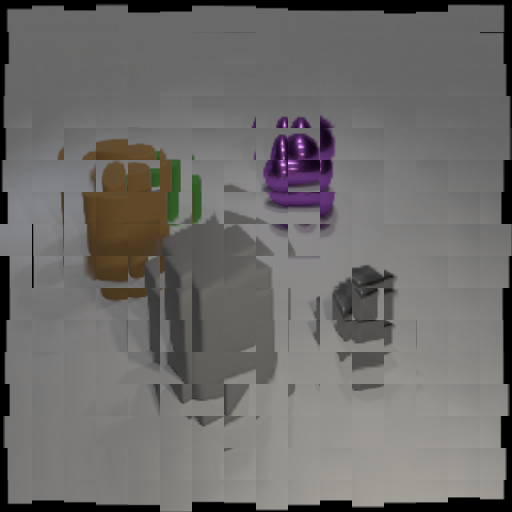

In [138]:
T.functional.to_pil_image(torchvision.utils.make_grid(xs, nrow=Hp, padding=0))

In [143]:
class GlimpseEncoder(nn.Module):
    def __init__(self,
                 ncs=[16, 32, 32, 64, 128, 256],
                 kss=[3, 4, 3, 4, 4, 4, 4],
                 ss=[1, 2, 1, 2, 2, 1],
                 ngs=[4, 8, 4, 8, 8, 16],
                 out_proj_dim=64,
                ):
        super().__init__()
        conv_layers = []
        prev_nc = 3
        for nc, ks, s, ng in zip(ncs, kss, ss, ngs):
            conv_layers.append(nn.Sequential(
                nn.Conv2d(
                    in_channels=prev_nc,
                    out_channels=nc,
                    kernel_size=ks,
                    stride=s,
                    padding=1,
                ),
                nn.GroupNorm(num_groups=ng, num_channels=nc),
                nn.CELU(),
            ))
            prev_nc = nc
        self.conv_layers = nn.Sequential(*conv_layers)
        self.out_proj = nn.Conv2d(
            in_channels=prev_nc,
            out_channels=out_proj_dim,
            kernel_size=1,
        )
        self.out_pool = nn.AvgPool2d(3, 3)
        
    def forward(self, x):
        return self.out_pool(self.out_proj(self.conv_layers(x)))
    
# GLIMPSE_SHAPE = (100, 100)
gencoder = GlimpseEncoder()
what_mean, what_log_std = gencoder(xs).chunk(2, 1)
z_what = sample_gaussean_sp(what_mean, what_log_std)

In [144]:
z_what.size()

torch.Size([256, 32, 1, 1])

In [156]:
from collections import OrderedDict

class GlimpseDecoder(nn.Module):
    def __init__(self,
                 conv_ncs=[256, 128, 128, 64, 32],
                 conv_ss=[1, 1, 1, 1, 1, 1],
                 conv_gns=[16, 16, 16, 8, 8],
                 conv_kss=[1, 3, 3, 3, 3],
                 conv_pds=[0, 1, 1, 1, 1],
                 sub_conv_factors=[2, 2, 2, 2, 2],
                 sub_conv_ncs=[128, 128, 64, 32, 16], # last item for first element edge case
                 sub_conv_ss=[1, 1, 1, 1, 1],
                 sub_conv_gns=[16, 16, 8, 8, 4],
                 
                 out_proj_dim=16,
                 out_proj_ks=3,
                 out_proj_stride=1,
                ):
        super().__init__()
        
        conv_layers = OrderedDict([])
        prev_num_channels = 32
        for i, (nc, ks, s, gn, pd, sc_f, sc_nc, sc_s, sc_gn) in enumerate(zip(conv_ncs, conv_kss, conv_ss, conv_gns, conv_pds, sub_conv_factors, sub_conv_ncs, sub_conv_ss, sub_conv_gns)):
            conv_layers[f'group_conv{i}'] = nn.Sequential(OrderedDict([
                    (f'conv{i}', nn.Sequential(
                        nn.Conv2d(
                            in_channels=prev_num_channels,
                            out_channels=nc,
                            kernel_size=ks,
                            stride=s,
                            padding=pd,
                        ),
                        nn.GroupNorm(num_groups=gn, num_channels=nc),
                        nn.CELU(),
                    )),
                    (f'sub_conv{i}', nn.Sequential(
                        nn.Conv2d(
                            in_channels=nc,
                            out_channels=sc_nc * sc_f ** 2,
                            stride=sc_s,
                            kernel_size=1,
                        ),
                        nn.PixelShuffle(sc_f),
                        nn.GroupNorm(num_groups=sc_gn, num_channels=sc_nc),
                        nn.CELU(),
                    )),
                ]))
            prev_num_channels = sc_nc                
        self.conv_layers = nn.Sequential(conv_layers)
        self.out_proj = nn.Sequential(
            nn.Conv2d(
                in_channels=prev_num_channels,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.GroupNorm(num_groups=4, num_channels=16),
            nn.CELU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=4,
                kernel_size=1,
            ),
        )
            
    def forward(self, x):
        return self.out_proj(self.conv_layers(x))
    
gdecoder = GlimpseDecoder()
gdecoder

GlimpseDecoder(
  (conv_layers): Sequential(
    (group_conv0): Sequential(
      (conv0): Sequential(
        (0): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): GroupNorm(16, 256, eps=1e-05, affine=True)
        (2): CELU(alpha=1.0)
      )
      (sub_conv0): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
        (1): PixelShuffle(upscale_factor=2)
        (2): GroupNorm(16, 128, eps=1e-05, affine=True)
        (3): CELU(alpha=1.0)
      )
    )
    (group_conv1): Sequential(
      (conv1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(16, 128, eps=1e-05, affine=True)
        (2): CELU(alpha=1.0)
      )
      (sub_conv1): Sequential(
        (0): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1))
        (1): PixelShuffle(upscale_factor=2)
        (2): GroupNorm(16, 128, eps=1e-05, affine=True)
        (3): CELU(alpha=1.0)
      )
    )
    (group_conv2): Sequential(

In [158]:
alpha_logits, o_logits = gdecoder(z_what).split((1, 3), dim=1)
alpha.size(), o.size()

(torch.Size([256, 1, 32, 32]), torch.Size([256, 3, 32, 32]))

In [152]:
z_pres.view(-1, 1, 1, 1).size()

torch.Size([256, 1, 1, 1])

In [153]:
alpha_hat = alpha * z_pres.view(-1, 1, 1, 1)

In [155]:
z_depth.size()

torch.Size([1, 16, 16, 1])

# Working Modules

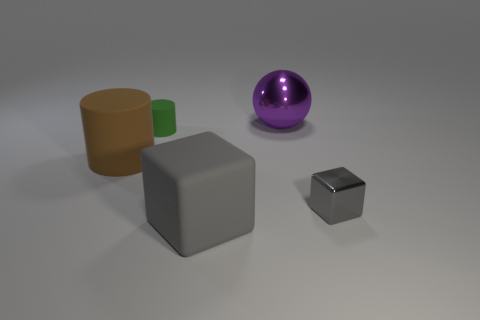

In [24]:
from modules import FG

fg = FG()
img = Image.open('/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/images/val/CLEVR_val_000000.png')
img = img.convert('RGB')

img

19 29 torch.Size([1, 64, 19, 29])
torch.Size([19, 29, 2])


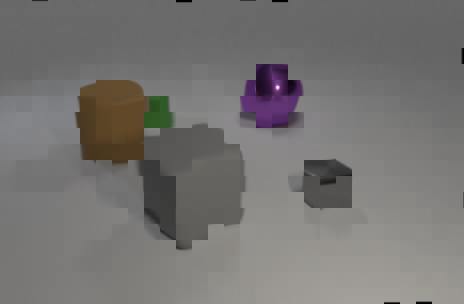

In [27]:
x = T.functional.to_tensor(img).unsqueeze(0)
xs = fg(x)
T.functional.to_pil_image(torchvision.utils.make_grid(xs, nrow=29, padding=0))

# Spatial Transformer

In [60]:
import torch.nn.functional as F
from torch.utils import data
from PIL import Image

In [38]:
img = Image.open('/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/images/val/CLEVR_val_000000.png')
img = img.convert('RGB')
x = np.array(img)
tensor_x = torch.Tensor(x)
my_dataset = data.TensorDataset(transforms.functional.to_tensor(np.array(img))[None])

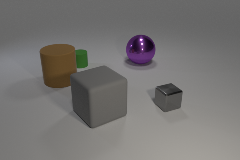

In [92]:
IMG_SIZE = (3, 160, 240)
_img = img.resize(IMG_SIZE[-1:0:-1])
x = torchvision.transforms.functional.to_tensor(_img).unsqueeze(0)
_img

theta
tensor([[[1.0000, 0.0000, 0.0000],
         [0.0000, 0.5000, 0.0000]]])
grid size
torch.Size([1, 80, 120, 2])


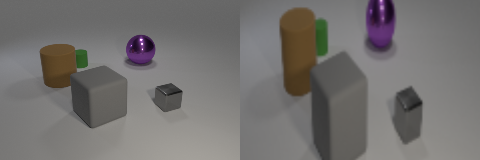

In [216]:
h, w = 0.5, 1
tx, ty = 0, 0
theta = torch.tensor([w, 0, tx, 0, h, tw], dtype=torch.float32)
theta = theta.view(1, 2, 3)
print('theta')
print(theta)
grid = F.affine_grid(theta, (1, 3, 80, 120), align_corners=True)
print('grid size')
print(grid.size())
_xs = F.grid_sample(x, grid, align_corners=True)
_xs_upsampled = F.interpolate(_xs, size=x.size()[2:], align_corners=True, mode='bilinear')
cat_images = torch.cat((x[0],_xs_upsampled[0]), dim=-1)
torchvision.transforms.functional.to_pil_image(cat_images)

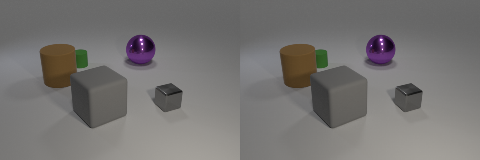

In [104]:
torchvision.transforms.functional.to_pil_image(torch.cat((x[0],_xs[0]), dim=-1))

In [168]:
conv = nn.Conv2d(1, 1, 3, stride=2, padding=1)

In [170]:
conv(torch.randn(1, 1, 32, 64)).size()

torch.Size([1, 1, 32, 32])

# Something

In [141]:
from modules import SceneEncoder, ImageEncoder, TransformDecoder
from misc_utils import select_and_pad_on_presence

In [157]:
def background_encoder():
    return nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(num_features=64, affine=True),
            nn.MaxPool2d(2),
            nn.ELU(),
            # nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2),
            # nn.BatchNorm2d(num_features=64, affine=True),
            # nn.ELU(),
            
            nn.Conv2d(64, 64 + 9, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(num_features=64 + 9, affine=True),
            nn.MaxPool2d(2),
            # nn.ELU(),
            # nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2),
            # nn.BatchNorm2d(num_features=64, affine=True), # spatial dim 1x1
            # nn.ELU(),
        )

In [171]:
_batch = torch.cat((batch, batch), 0)
img_enc = ImgEncoder()
bg_enc = background_encoder()
scene_enc = SceneEncoder()
transform_dec = TransformDecoder(128)

img_feats = img_enc(_batch)
print('Image features:', img_feats.size(), end='\n\n')

bg_feats = bg_enc(img_feats).squeeze(-1).squeeze(-1)
print('Bg features:', bg_feats.size(), end='\n\n')
bg_transform_params = process_decoded_transform(bg_feats[..., -9:])
print('Bg transform params:', bg_transform_params.size())

glimpses_info = scene_enc.get_glimpses(_batch, img_feats, )
print('Glimpses info:')
for k, v in glimpses_info.items():
    print(f'{k}: {v.size()}')
print()

obj_pres = glimpses_info['obj_pres'].squeeze(-1)
img_feats = img_feats.permute(0, 2, 3, 1).contiguous()
scale, center = (
    glimpses_info["z_scale_wrt_img"],
    glimpses_info["z_center_wrt_img__11"],
)
valid_img_feats = select_and_pad_on_presence(img_feats, obj_pres)
valid_scale = select_and_pad_on_presence(scale, obj_pres)
valid_center = select_and_pad_on_presence(center, obj_pres)
img_transforms = transform_dec(valid_img_feats, valid_scale, valid_center)
print('Image transforms:', img_transforms.size())
print()

fg_transform_params = process_decoded_transform(img_transforms)

Image features: torch.Size([2, 128, 16, 16])

Bg features: torch.Size([2, 73])

Bg transform params: torch.Size([2, 9])
Glimpses info:
pres_p_logits: torch.Size([2, 16, 16, 1])
scale_mean: torch.Size([2, 16, 16, 2])
scale_log_std: torch.Size([2, 16, 16, 2])
center_shift_mean: torch.Size([2, 16, 16, 2])
center_shift_log_std: torch.Size([2, 16, 16, 2])
obj_pres: torch.Size([2, 16, 16, 1])
z_scale: torch.Size([2, 16, 16, 2])
z_shift: torch.Size([2, 16, 16, 2])
z_scale_wrt_img: torch.Size([2, 16, 16, 2])
z_center_wrt_img__11: torch.Size([2, 16, 16, 2])

Image transforms: torch.Size([2, 140, 9])



In [168]:
process_decoded_transform(img_transforms)

tensor([[[-0.2976,  1.0165, -0.5029,  ..., -0.6911, -1.0000, -0.5425],
         [-0.5448,  0.9706, -0.3690,  ..., -0.1788, -1.0000, -0.5931],
         [-0.5488,  1.3669,  0.0825,  ..., -0.1064, -1.0000, -0.5100],
         ...,
         [ 0.0526, -0.5061,  0.0847,  ..., -0.0427, -0.0773,  0.2362],
         [-0.2786, -0.4987, -0.6670,  ..., -0.0690, -0.4979,  0.6761],
         [ 0.2178,  0.1605, -0.4604,  ...,  0.0708, -0.2703,  0.4069]],

        [[-0.1157,  0.8830,  0.5146,  ..., -0.2630,  0.1224, -0.3330],
         [-0.3581,  1.1726, -0.5366,  ..., -0.6902, -1.0000, -0.4614],
         [-0.5127,  0.9608, -0.3110,  ..., -0.1737, -1.0000, -0.6430],
         ...,
         [ 0.1084,  0.0914, -0.0397,  ..., -0.1027, -0.0372,  0.0264],
         [ 0.1084,  0.0914, -0.0397,  ..., -0.1027, -0.0372,  0.0264],
         [ 0.1084,  0.0914, -0.0397,  ..., -0.1027, -0.0372,  0.0264]]],
       grad_fn=<CopySlices>)

In [164]:
def process_decoded_transform(transform):
    transform[..., :3] = torch.fmod(transform[..., :3], math.pi) # .chunk(3, -1)
    transform[..., 3:6] = torch.clamp(transform[..., 3:6], 0.5, 1.5) # .chunk(3, -1)
    transform[..., 6:] = torch.clamp(transform[..., 6:], -1, 1)# .chunk(3, -1)
    return transform

In [142]:
def select_and_pad_on_presence(features, presence):
    indexes = presence >= 0.5
    lengths = indexes.sum((1, 2)).tolist()
    sequences = features[indexes].split(lengths, 0)
    return pad_sequence(sequences, batch_first=True)

In [143]:
import math

In [149]:
torch.fmod(torch.arange(-5, 5, 0.2).requires_grad_(True), math.pi)

tensor([-1.8584, -1.6584, -1.4584, -1.2584, -1.0584, -0.8584, -0.6584, -0.4584,
        -0.2584, -0.0584, -3.0000, -2.8000, -2.6000, -2.4000, -2.2000, -2.0000,
        -1.8000, -1.6000, -1.4000, -1.2000, -1.0000, -0.8000, -0.6000, -0.4000,
        -0.2000,  0.0000,  0.2000,  0.4000,  0.6000,  0.8000,  1.0000,  1.2000,
         1.4000,  1.6000,  1.8000,  2.0000,  2.2000,  2.4000,  2.6000,  2.8000,
         3.0000,  0.0584,  0.2584,  0.4584,  0.6584,  0.8584,  1.0584,  1.2584,
         1.4584,  1.6584], grad_fn=<FmodBackward0>)

In [148]:
torch.arange(math.radians(-180), math.radians(180), 0.5)

tensor([-3.1416, -2.6416, -2.1416, -1.6416, -1.1416, -0.6416, -0.1416,  0.3584,
         0.8584,  1.3584,  1.8584,  2.3584,  2.8584])

In [106]:
obj_pres = glimpses_info['obj_pres']

In [124]:
indexes = obj_pres.squeeze(-1) >= 0.5

In [128]:
indexes.sum((1, 2))

tensor([102, 118])

In [117]:
(obj_pres >= 0.5).sum(axis=(1, 2, 3)).tolist()

[102, 118]

In [123]:
pad_sequence(img_feats[obj_pres.squeeze(-1) >= 0.5].split((obj_pres >= 0.5).sum(axis=(1, 2, 3)).tolist(), 0), batch_first=True).size()

torch.Size([2, 118, 128])

In [121]:
from torch.nn.utils.rnn import PackedSequence, pad_packed_sequence, pad_sequence

In [111]:
pack = PackedSequence(img_feats[obj_pres.squeeze(-1) >= 0.5], (obj_pres >= 0.5).sum(axis=(1, 2, 3)))

In [114]:
pack

PackedSequence(data=tensor([[-0.7419, -0.0161,  0.2470,  ...,  0.0465,  0.5966,  0.8395],
        [-0.7424,  0.1268, -0.2302,  ..., -0.1326,  0.6382,  0.8822],
        [-0.6894,  0.0296,  0.0069,  ...,  0.0280,  0.3668,  1.2240],
        ...,
        [-0.0515, -0.2704, -0.1130,  ..., -0.6437,  0.0508,  0.3653],
        [-0.1984, -0.1631, -0.1914,  ..., -0.6413, -0.2668,  0.4232],
        [ 0.5391,  0.1819, -0.8577,  ..., -0.4755, -0.4369, -0.1104]],
       grad_fn=<IndexBackward>), batch_sizes=tensor([102, 118]), sorted_indices=None, unsorted_indices=None)

In [113]:
pad_packed_sequence(pack, batch_first=True)

RuntimeError: The size of tensor a (102) must match the size of tensor b (118) at non-singleton dimension 1